All the training scripts is in the github: [sinhajiya/hf_emotion_classifier](https://github.com/sinhajiya/hf_emotion_classifier.git)

Also, i have stored the model weights in google drive: [https://drive.google.com/drive/folders/1176dlKl5ZOiFk4ahkHex4pc5lEROz4YZ?usp=sharing](https://drive.google.com/drive/folders/1176dlKl5ZOiFk4ahkHex4pc5lEROz4YZ?usp=sharing)


#### importing

In [3]:
!git clone https://github.com/sinhajiya/hf_emotion_classifier.git
# from google.colab import drive
# drive.mount('/content/gdrive')

fatal: destination path 'hf_emotion_classifier' already exists and is not an empty directory.


In [4]:
!pip install gdown
weights = 'https://drive.google.com/drive/folders/1176dlKl5ZOiFk4ahkHex4pc5lEROz4YZ?usp=sharing'
!gdown --folder "https://drive.google.com/drive/folders/1176dlKl5ZOiFk4ahkHex4pc5lEROz4YZ"


Retrieving folder contents
Retrieving folder 1glTcmdnrPjihHX445l5MEJz14CgKwGpG .ipynb_checkpoints
Retrieving folder 1CY-XQ5Rz2QZw4QQPPE0ovcaP9WSTs5_r bert
Retrieving folder 1GPZNqg_f6yDEjKXYd7DIII3vroKNT_Fz final_model
Processing file 1YMwZAGdc8eGHGtIWHwk1n8LzRp0jslVW config.json
Processing file 1FFw6W91FNvzNkk4u9Vdus_RWk-nQTiBE model.safetensors
Processing file 1mYsY1tsN2KeyeTqXq5hWKLi6uYiWWQ-9 special_tokens_map.json
Processing file 1A1EF6zJ8tyf56xzPiIhFeyIETln6GPhl tokenizer_config.json
Processing file 1DhOh7TyFxo1hJ66_ktXgB0LwXteeF4a9 tokenizer.json
Processing file 1FSpQ4D26zqJCJ_Di6B39s5InJGQspbA3 training_args.bin
Processing file 1C4s0-2gMtq5Lgpu12PW7FF6oRwQaFGqn vocab.txt
Retrieving folder 1p3dKoFlDuB037G7btovBqc39tyfzkXxP ptq
Processing file 1mQA7ok9hvxUiKK78FGqi8VjNzUllk6zg quantized_model.pt
Processing file 1UCfoGeNd5KejD9FnYo_s8kvi3ZYosIH6 special_tokens_map.json
Processing file 1GCEGbtC8ECGMw-ZVI0nOSj-UUNIeTFpu tokenizer_config.json
Processing file 1NFTULonn2sGhSARNYzjwZlhe

In [6]:
!pip install evaluate


In [13]:
# finetune_model_dir = '/content/gdrive/MyDrive/ANLP_weights/bert/final_model'
# ptq_model_path = '/content/drive/MyDrive/ANLP_weights/ptq'
# qat_model_path = '/content/gdrive/MyDrive/ANLP_weights/distilbert-qat-model'
# qlora_path = '/content/gdrive/MyDrive/ANLP_weights/qlora_adapter'

finetune_model_dir = '/content/ANLP_weights/bert/final_model'
ptq_model_path = '/content/ANLP_weights/ptq'
qat_path = '/content/ANLP_weights/qat'
qlora_path = '/content/ANLP_weights/qlora_adapter'

In [8]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import sys
project_root = os.path.abspath("/content/hf_emotion_classifier")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from hf_data import *
from metrics import summarize_evaluation

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'

#### dataset

In [10]:
test = emotions('test')
tokenizer = AutoTokenizer.from_pretrained(finetune_model_dir)


tokenized_test = test.map(lambda x: tokenize_batch(x, tokenizer), batched=True)
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

print(tokenized_test)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2000
})


#### fine-tuned model inference

In [ ]:
ft_model = AutoModelForSequenceClassification.from_pretrained(finetune_model_dir)

ft_model = ft_model.to(device)
ft_model.eval()

print("Fine-tuned model loaded")
print(f"Model type: {type(ft_model)}")

Fine-tuned model loaded
Model type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [ ]:
test_loader = DataLoader(tokenized_test, batch_size=16)
predictions, labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device)
        }
        outputs = ft_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        labels.extend(batch["label"].numpy())
        predictions.extend(preds)

Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.74it/s]



Fine-tuned Evaluation Summary
trainable params: 109486854 || all params: 109486854 || trainable%: 100.00


model size: 417.667MB


/content/hf_emotion_classifier/metrics.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single[key] = torch.tensor(test_subset[i][key]).unsqueeze(0).to(device)


Accuracy:       0.9290
Macro F1:       0.8792
Latency:        33.57 ms/sample

Per-Class F1 Scores:
  sadness        : 0.9707
  joy            : 0.9520
  love           : 0.8014
  anger          : 0.9248
  fear           : 0.8962
  surprise       : 0.7299


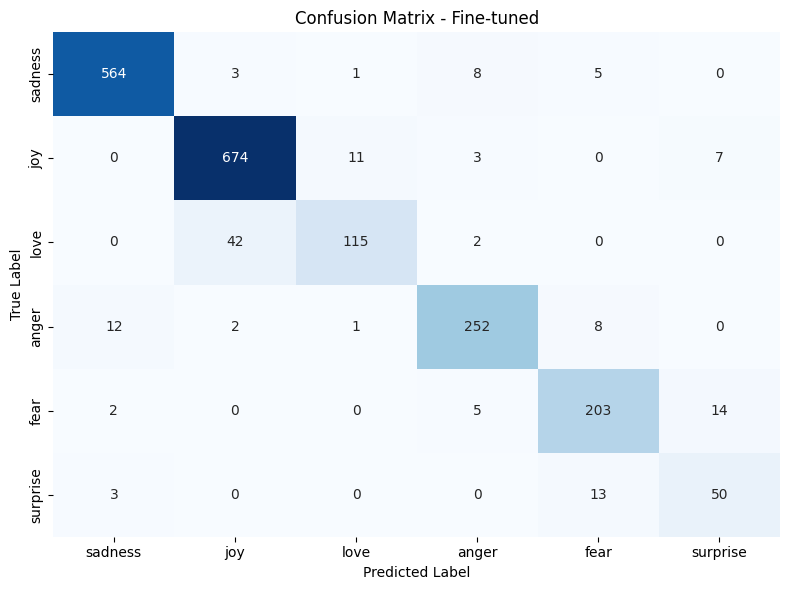

In [ ]:
results = summarize_evaluation(
    model=ft_model,
    dataset=tokenized_test,
    predictions=predictions,
    labels=labels,
    model_name="Fine-tuned",
    num_classes=6
)



#### ptq model

In [ ]:
device = torch.device("cpu")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(ptq_model_path)
ptq_model = torch.load("/content/drive/MyDrive/ANLP_weights/ptq/quantized_model.pt", map_location=device,weights_only=False)
ptq_model.eval()

print("PTQ model loaded successfully.")
print(type(ptq_model))


/usr/local/lib/python3.12/dist-packages/torch/_utils.py:444: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


PTQ model loaded successfully.
<class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>


In [ ]:
test_loader = DataLoader(tokenized_test, batch_size=16)
predictions, labels = [], []

ptq_model.eval()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        inputs = {
            "input_ids": batch["input_ids"].to(device),
            "attention_mask": batch["attention_mask"].to(device)
        }
        outputs = ptq_model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
        predictions.extend(preds)
        labels.extend(batch["label"].numpy())


Evaluating: 100%|██████████| 125/125 [08:27<00:00,  4.06s/it]



PTQ Evaluation Summary
trainable params: 23874048 || all params: 23874048 || trainable%: 100.00
model size: 91.080MB


/content/hf_emotion_classifier/metrics.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single[key] = torch.tensor(test_subset[i][key]).unsqueeze(0).to(device)


Accuracy:       0.9255
Macro F1:       0.8754
Latency:        254.57 ms/sample

Per-Class F1 Scores:
  sadness        : 0.9667
  joy            : 0.9484
  love           : 0.7875
  anger          : 0.9314
  fear           : 0.8848
  surprise       : 0.7338


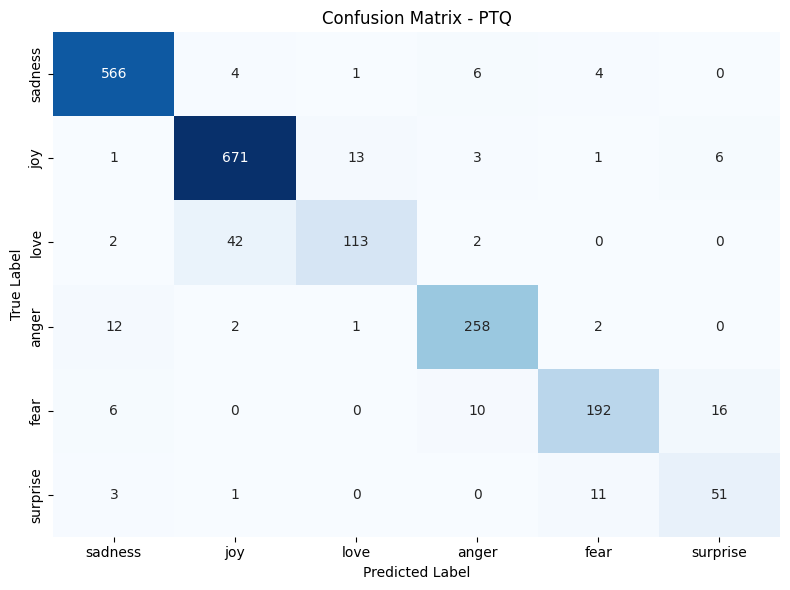

In [ ]:
results = summarize_evaluation(
    model=ptq_model,
    dataset=tokenized_test,
    predictions=predictions,
    labels=labels,
    model_name="PTQ",
    num_classes=6
)


#### QAT inference

In [12]:
import gdown, zipfile

from sklearn.preprocessing import LabelEncoder
from transformers import BertModel, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import joblib
import torch.nn as nn
import torch.ao.quantization as quant


In [14]:
class EmotionPredictorQuant(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        self.num_labels = num_labels

        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        torch.backends.quantized.engine = "fbgemm"
        self.qconfig = quant.get_default_qat_qconfig("fbgemm")

        # Do not quantize embeddings
        self.bert.embeddings.qconfig = None

        quant.prepare_qat(self, inplace=True)

    def load_prepared_state(self, artifacts_dir, device="cpu"):
        sd = torch.load(os.path.join(artifacts_dir, "prepared_qat_state.pt"),
                        map_location=device)
        self.load_state_dict(sd, strict=False)
        self.to(device)
        self.eval()
        print(f"[QAT] Loaded QAT model from {artifacts_dir} onto {device}")

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.bert(input_ids=input_ids,
                        attention_mask=attention_mask,
                        return_dict=True)
        pooled = out.last_hidden_state[:, 0]
        logits = self.classifier(pooled)

        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
            return loss, logits
        return None, logits


def load_prepared_qat_for_inference(artifacts_dir=qat_path, device="cpu"):
    meta = joblib.load(os.path.join(artifacts_dir, "meta.pkl"))
    tokenizer = BertTokenizerFast.from_pretrained(artifacts_dir)
    label_encoder = joblib.load(os.path.join(artifacts_dir, "label_encoder.pkl"))

    num_labels = meta["num_labels"]
    model = EmotionPredictorQuant(num_labels)
    model.load_prepared_state(artifacts_dir, device=device)

    return model, tokenizer, label_encoder


class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


def make_cpu_test_loader(test_df, tokenizer):
    ds = EmotionDataset(test_df, tokenizer, 128)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


def predict_texts(model, tokenizer, label_encoder, texts, device="cpu"):
    enc = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        _, logits = model(enc["input_ids"], enc["attention_mask"])

    preds = logits.argmax(1).cpu().numpy()
    return label_encoder.inverse_transform(preds)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/tmp/ipython-input-3614185440.py:15: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quant.prepare_qat(self, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  war

[QAT] Loaded QAT model from /content/ANLP_weights/qat onto cpu


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Evaluating: 100%|██████████| 125/125 [13:50<00:00,  6.64s/batch]



BERT-QAT Evaluation Summary
trainable params: 109486854 || all params: 109486854 || trainable%: 100.00


model size: 418.949MB


/content/hf_emotion_classifier/metrics.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single[key] = torch.tensor(test_subset[i][key]).unsqueeze(0).to(device)


Accuracy:       0.9245
Macro F1:       0.8796
Latency:        1684.89 ms/sample

Per-Class F1 Scores:
  sadness        : 0.9617
  joy            : 0.9417
  love           : 0.8228
  anger          : 0.9251
  fear           : 0.9004
  surprise       : 0.7258


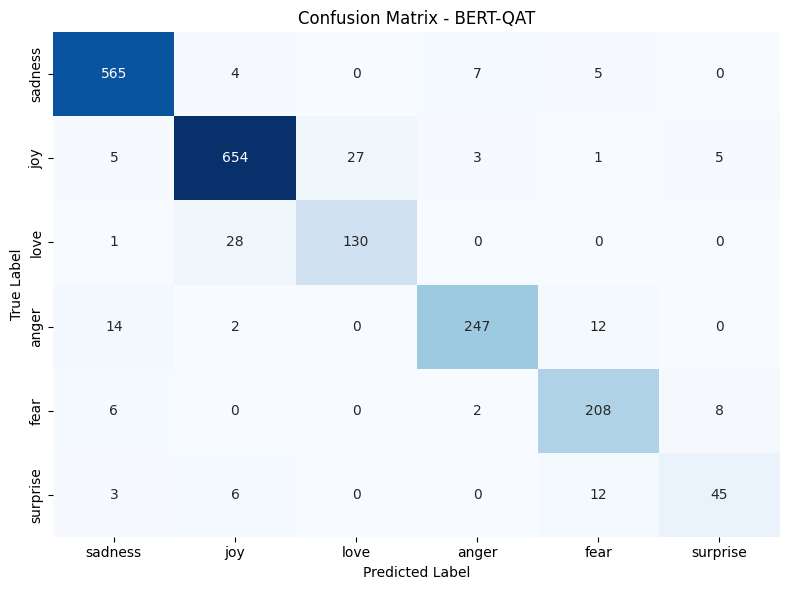

{'accuracy': 0.9245,
 'macro_f1': 0.8795840980029239,
 'per_class_f1': [0.9617021276595744,
  0.9416846652267818,
  0.8227848101265823,
  0.9250936329588015,
  0.9004329004329005,
  0.7258064516129032],
 'confusion_matrix': [[565, 4, 0, 7, 5, 0],
  [5, 654, 27, 3, 1, 5],
  [1, 28, 130, 0, 0, 0],
  [14, 2, 0, 247, 12, 0],
  [6, 0, 0, 2, 208, 8],
  [3, 6, 0, 0, 12, 45]],
 'latency_ms': 1684.887204170227}

In [15]:
model, qat_tokenizer, label_encoder = load_prepared_qat_for_inference(
    qat_path, device="cpu"
)

device = torch.device("cpu")
model.to(device)
model.eval()
tokenized_test = test.map(lambda x: tokenize_batch(x, qat_tokenizer), batched=True)
tokenized_test.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_loader = DataLoader(tokenized_test, batch_size=16, shuffle=False)


all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating", unit="batch"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].numpy()

        _, logits = model(input_ids, attention_mask)
        preds = logits.argmax(dim=1).cpu().numpy()

        # collect raw labels + predictions
        all_labels.extend(labels)
        all_preds.extend(preds)

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

summarize_evaluation(
    model=model,
    dataset=tokenized_test,
    predictions=all_preds,
    labels=all_labels,
    model_name="QAT"
)


## qlora

In [ ]:
import torch
from torch.utils.data import DataLoader

from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding

from peft import LoraConfig, get_peft_model, TaskType
import evaluate
from peft import PeftModel


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 63/63 [00:13<00:00,  4.52it/s]



QLoRA Evaluation Summary
trainable params: 4614 || all params: 110081292 || trainable%: 0.00
model size: 419.935MB


/content/hf_emotion_classifier/metrics.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  single[key] = torch.tensor(test_subset[i][key]).unsqueeze(0).to(device)


Accuracy:       0.7325
Macro F1:       0.5405
Latency:        15.49 ms/sample

Per-Class F1 Scores:
  sadness        : 0.8009
  joy            : 0.8592
  love           : 0.0120
  anger          : 0.4485
  fear           : 0.6978
  surprise       : 0.4242


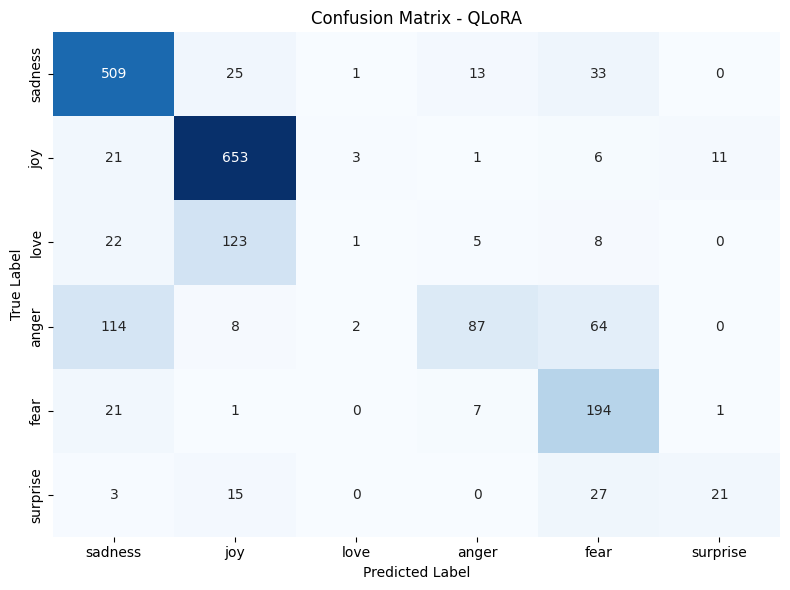

In [ ]:
tokenized_test.set_format(type="torch", columns=["input_ids","attention_mask","label"])


base_model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6
).to(device)

model = PeftModel.from_pretrained(base_model, qlora_path).to(device)
model.eval()

preds = []
labels = []
BATCH_SIZE = 32

for i in tqdm(range(0, len(tokenized_test), BATCH_SIZE)):
    batch = tokenized_test[i:i+BATCH_SIZE]
    input_ids = batch["input_ids"].to(device)
    mask = batch["attention_mask"].to(device)
    y_true = batch["label"].tolist()

    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=mask).logits
        y_pred = logits.argmax(dim=-1).cpu().tolist()

    preds.extend(y_pred)
    labels.extend(y_true)

summary = summarize_evaluation(
    model=model,
    dataset=tokenized_test,
    predictions=preds,
    labels=labels,
    model_name="QLoRA"
)


In [ ]:
|